In [2]:
using BenchmarkTools
using LinearAlgebra
using Plots

include("parallelized_DLA.jl")

Main.Utils

## Step 0: Initialize cluster

In [93]:
desired_cluster_mass = 100

cluster = []
sizehint!(cluster, desired_cluster_mass+1)
push!(cluster, [0,0])

1-element Vector{Any}:
 [0, 0]

## Step 1: Get grid points from a birth circle

In [3]:
r = 12
θ = range(-π, π, 300)

grid_circle = Utils.get_circle_points(r)
round_circle = [r * cos.(θ), r* sin.(θ)]

2-element Vector{Vector{Float64}}:
 [-12.0, -11.997350568906894, -11.989403445541763, -11.976162139130562, -11.957632496661448, -11.933822700302901, -11.90474326379072, -11.870407027785454, -11.830829154202313, -11.78602711951611  …  -11.78602711951611, -11.830829154202313, -11.870407027785454, -11.90474326379072, -11.933822700302901, -11.957632496661448, -11.976162139130562, -11.989403445541763, -11.997350568906894, -12.0]
 [-1.4695761589768238e-15, -0.25214941354170717, -0.5041874850006886, -0.7560029214597506, -1.0074845283110418, -1.258521258356483, -1.5090022608430538, -1.7588169304113834, -2.007854955935961, -2.2560063692354215  …  2.2560063692354215, 2.007854955935961, 1.7588169304113834, 1.5090022608430538, 1.258521258356483, 1.0074845283110418, 0.7560029214597506, 0.5041874850006886, 0.25214941354170717, 1.4695761589768238e-15]

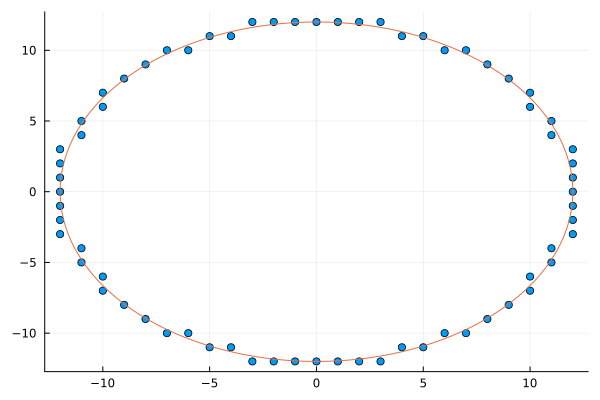

In [4]:
fig = scatter([v[1] for v in grid_circle], [v[2] for v in grid_circle], label="")
plot!(fig, (round_circle[1], round_circle[2]), label="")

#### Get number of grid points for each radius

In [5]:
radii = collect(1:80)
num_gridpoints_on_circle = map(
    x -> length(Utils.get_circle_points(x)),
    radii
)
;

Perform linear regression

In [6]:
using DataFrames, GLM, StatsBase

In [7]:
data = DataFrame(X=radii, Y=num_gridpoints_on_circle)
ols = lm(@formula(Y ~ X), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
───────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error        t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────
(Intercept)  -0.110127  0.263293      -0.42    0.6769  -0.634303   0.414049
X             5.65827   0.00564754  1001.90    <1e-99   5.64703    5.66952
───────────────────────────────────────────────────────────────────────────

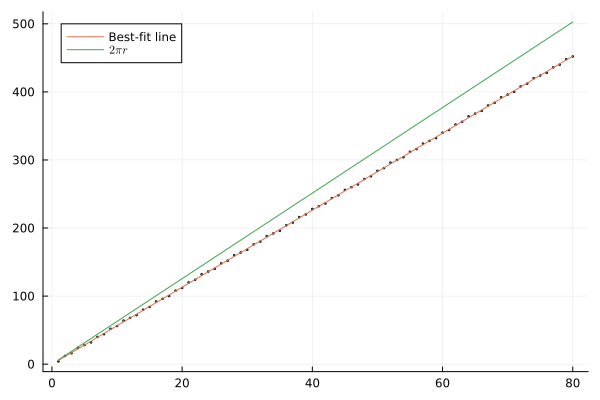

In [8]:
fig = scatter(radii, num_gridpoints_on_circle, markersize=1, label="")
plot!(fig, (radii, predict(ols)), label="Best-fit line")

plot!(fig, (radii, (2*pi) .* radii), label=raw"$2\pi r$")

#### Benchmarking

In [9]:
r = 100_000
@benchmark Utils.get_circle_points($r)

BenchmarkTools.Trial: 10000 samples with 997 evaluations.
 Range (min … max):  22.166 ns …  6.111 μs  ┊ GC (min … max): 0.00% … 98.90%
 Time  (median):     25.577 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   29.073 ns ± 86.010 ns  ┊ GC (mean ± σ):  4.49% ±  1.70%

  ▅▆▅▆█▇▆▄▄▃▃▃▃▂▁               ▁                             ▂
  ████████████████▇▆▇▆▇▇▇▆█████████▇▇▇▇█▇▆▆▆▆▅▆▆▅▅▅▆▆▅▆▄▅▆▅▆▆ █
  22.2 ns      Histogram: log(frequency) by time      62.6 ns <

 Memory estimate: 16 bytes, allocs estimate: 1.

# Step 2: Generate random walks

#### Determine the number of walkers for a given birth circle by imposing a constant density.

In [95]:
start_radius = 10
density = 0.7
num_steps = 1000

num_points = num_gridpoints_on_circle[start_radius]
num_walkers = Int(floor(density * num_points))
print("We chose $num_walkers points (out of $num_points) on the circle of radius $start_radius.")

trajectories = DLA_parallel.generate_trajectories(
    num_walkers,
    num_steps,
    start_radius
)

We chose 39 points (out of 56) on the circle of radius 10.

1001×39 Matrix{Vector{Int64}}:
 [-5, 9]    [0, 10]   [-9, 5]   [10, 0]   …  [9, 4]   [3, 10]   [10, -3]
 [-4, 9]    [1, 10]   [-9, 6]   [9, 0]       [8, 4]   [3, 9]    [10, -2]
 [-3, 9]    [2, 10]   [-9, 5]   [10, 0]      [8, 5]   [4, 9]    [9, -2]
 [-3, 10]   [1, 10]   [-9, 4]   [9, 0]       [7, 5]   [4, 10]   [10, -2]
 [-3, 11]   [2, 10]   [-8, 4]   [9, -1]      [7, 6]   [4, 9]    [10, -1]
 [-3, 10]   [1, 10]   [-7, 4]   [8, -1]   …  [6, 6]   [4, 10]   [11, -1]
 [-2, 10]   [0, 10]   [-7, 3]   [7, -1]      [7, 6]   [4, 11]   [12, -1]
 [-3, 10]   [-1, 10]  [-6, 3]   [7, 0]       [8, 6]   [5, 11]   [12, -2]
 [-3, 9]    [-1, 9]   [-6, 4]   [6, 0]       [7, 6]   [6, 11]   [12, -3]
 [-3, 10]   [-1, 10]  [-6, 5]   [5, 0]       [7, 5]   [5, 11]   [13, -3]
 ⋮                                        ⋱                     
 [39, -31]  [12, 60]  [15, 31]  [14, 38]     [2, 55]  [36, -3]  [50, 9]
 [38, -31]  [11, 60]  [14, 31]  [14, 39]     [2, 56]  [37, -3]  [51, 9]
 [38, -32]  [12, 60]  [15, 31] 

Each column comprises the trajectory of a particular walker, and each row represents one step made by each walker.

# Step 3: Process each trajectory

### Iterate only over cluster points near the walker

In [34]:
ex_start_radius = 3
ex_num_steps = 100
ex_density = 0.3

ex_num_points = num_gridpoints_on_circle[ex_start_radius]
ex_num_walkers = Int(floor(ex_density * ex_num_points))

ex_trajectories = DLA_parallel.generate_trajectories(
    ex_num_walkers,
    ex_num_steps,
    ex_start_radius
)

print(ex_trajectories[:, 1])

[[1, -3], [0, -3], [-1, -3], [-1, -4], [-1, -3], [-1, -2], [-1, -1], [-1, 0], [-1, 1], [0, 1], [0, 0], [1, 0], [1, 1], [2, 1], [1, 1], [1, 0], [1, 1], [1, 0], [0, 0], [0, -1], [-1, -1], [-1, -2], [-1, -3], [0, -3], [0, -2], [0, -1], [0, -2], [1, -2], [2, -2], [1, -2], [2, -2], [1, -2], [0, -2], [0, -1], [0, -2], [0, -1], [0, 0], [-1, 0], [0, 0], [0, -1], [0, -2], [1, -2], [0, -2], [-1, -2], [-2, -2], [-1, -2], [-2, -2], [-3, -2], [-4, -2], [-3, -2], [-3, -1], [-3, 0], [-3, 1], [-4, 1], [-4, 0], [-4, 1], [-4, 0], [-4, 1], [-4, 0], [-5, 0], [-4, 0], [-5, 0], [-5, -1], [-4, -1], [-4, 0], [-3, 0], [-4, 0], [-4, -1], [-4, -2], [-4, -1], [-5, -1], [-5, 0], [-4, 0], [-5, 0], [-5, 1], [-5, 0], [-5, 1], [-5, 2], [-5, 1], [-6, 1], [-6, 0], [-7, 0], [-7, 1], [-7, 2], [-6, 2], [-6, 1], [-5, 1], [-4, 1], [-4, 2], [-4, 3], [-5, 3], [-5, 2], [-5, 3], [-5, 2], [-6, 2], [-6, 1], [-6, 2], [-7, 2], [-7, 3], [-7, 4], [-7, 3]]

In [35]:
ex_trajectory = ex_trajectories[:, 1]
ex_step = ex_trajectory[4]

ex_max_radius = 2
ex_cluster = [[0,0], [0,1], [0,2], [0, -1], [0,-2], [0,-3]]

6-element Vector{Vector{Int64}}:
 [0, 0]
 [0, 1]
 [0, 2]
 [0, -1]
 [0, -2]
 [0, -3]

#### Implementation

In [96]:
function is_adjacent_to_cluster_bf(step, cluster)
    directions = [[1,0], [-1,0], [0,1], [0,-1]]
    for deposit in cluster
        for direction in directions
            if step == (deposit + direction)
                return true
            end
        end
    end
    return false
end


function is_adjacent_to_cluster_min(step, cluster)
    walker_cluster_distances = norm.(cluster .- Ref(step))
    if abs(minimum(walker_cluster_distances) - 1) <= 1e-6
        return true
    end
    return false
end

is_adjacent_to_cluster_min (generic function with 1 method)

In [97]:
deposit_probability = 1.0
cluster_radius = 56  # maximum(norm.(cluster))
death_radius = Int(floor(1.5 * cluster_radius))
closeness = 5


for trajectory in eachcol(trajectories)
    for step in trajectory

        # Skip walker if it strays beyond a death circle
        if norm(step) > death_radius
            break
        end

        # Prune the cluster points far away from the walker
        # closest_cluster_points = filter(
        #   x -> norm.(x .- Ref(step)) < closeness,
        #   cluster
        # )

        if is_adjacent_to_cluster_min(step, cluster)
            if rand(Uniform(0.0, 1.0)) < deposit_probability
                push!(cluster, step)
                break
            end
        end
    end
end

print(num_skipped)

10

In [98]:
cluster

14-element Vector{Any}:
 [0, 0]
 [1, 0]
 [1, 1]
 [1, 2]
 [0, -1]
 [0, -2]
 [0, -3]
 [2, 0]
 [1, -3]
 [1, 3]
 [2, -3]
 [0, 1]
 [3, 0]
 [4, 0]

## Function packing

In [62]:
function generate_trajectories(num_walkers, num_steps, birth_radius)
    directions = [[1, 0], [-1, 0], [0, 1], [0, -1]]  # constrains the movement of the particle to lattice sites

    trajectories = rand(directions, (num_steps+1, num_walkers))
    trajectories[1, :] = rand(Utils.get_circle_points(birth_radius), num_walkers)
    
    return cumsum(trajectories, dims=1)
end


function is_adjacent_to_cluster(step, cluster)
    walker_cluster_distances = norm.(cluster .- Ref(step))
    if abs(minimum(walker_cluster_distances) - 1) <= 1e-6
        return true
    end
    return false
end

"""
    run_parallel_DLA(desired_cluster_mass, spawn_density,  num_steps, max_radius, spawn_cap, deposit_prob)

Args:
- `desired_cluster_mass::Int`: Desired number of particles in the cluster
- `spawn_density::Float`: Must be between 0 and 1, exclusive (usually set to 0.8).
Prevents there being more particles than choices of where to place them on the birth circle, especially towards the start of the simulation.
- `num_steps::Int`: Set to a large number >= 10_000. Number of steps that each particle can walk when generated in parallel.
- `max_radius::Int`: Set to about 150-300. Maximum radius of the birth and death circles.
- `spawn_cap::Int`: Caps the maximum number of particles that can be generated at one time.
- `deposit_prob::Float`: Must be between 0 and 1, inclusive. The probability that a particle attaches to the cluster when there is contact between the two.
"""
function run_parallel_DLA(desired_cluster_mass, spawn_density,  num_steps, max_radius, spawn_cap = 300, deposit_prob = 1)

    # Initialize cluster and place a seed at the origin
    cluster = []
    sizehint!(cluster, desired_cluster_mass+1)
    push!(cluster, [0,0])

    # Initialize dynamic variables
    birth_radius = 1
    death_radius = 3
    num_walkers = 3

    while length(cluster) < desired_cluster_mass

        if num_walkers < spawn_cap
            num_walkers = Int(floor(spawn_density * 5.651 * birth_radius))  # 5.651 determined by linear regression of the radii versus
                                                                            #  the number of grid points on a circle of that radius
        else
            num_steps = spawn_cap
        end
        
        # Generate random walks
        trajectories = generate_trajectories(num_walkers, num_steps, birth_radius)

        # Determine fate of each walker
        for trajectory in eachcol(trajectories)
            for step in trajectory

                # Skip walkers beyond a death circle
                if norm(step) > death_radius
                    break
                end

                # Get only the cluster points closest to the walker
                closest_cluster_points = filter(
                    x -> norm(x - step) < 2,  # 2 is arbitrary 
                    cluster
                )

                # If there are no nearby cluster points, skip to next step
                if length(closest_cluster_points) == 0
                    continue
                end

                if is_adjacent_to_cluster(step, closest_cluster_points)
                    if rand() < deposit_prob
                        push!(cluster, step)
                        break
                    end
                end

            end
            
            # End when cluster achieves desired mass
            if length(cluster) >= desired_cluster_mass
                break
            end

            print("\r Mass = $(length(cluster)), r_B = $(birth_radius), r_D = $(death_radius) ")
        end

        # Update birth and death radii
        cluster_radius = maximum(norm.(cluster))
        if death_radius < max_radius
            birth_radius = Int(floor(cluster_radius + 1))
            death_radius = 2 * birth_radius
        else
            if birth_radius <= max_radius
                birth_radius = Int(floor(cluster_radius + 1))
            else
                birth_radius = max_radius
            end
            death_radius = max_radius
        end
    end
    return cluster
end

run_parallel_DLA

In [63]:
@time cluster = run_parallel_DLA(2500, 0.8, 10_000, 150)

 Mass = 2499, r_B = 61, r_D = 122 288.699714 seconds (4.11 G allocations: 200.563 GiB, 16.04% gc time, 0.01% compilation time)


2500-element Vector{Any}:
 [0, 0]
 [-1, 0]
 [1, 0]
 [-2, 0]
 [0, 1]
 [0, -1]
 [1, -1]
 [0, -2]
 [-3, 0]
 [0, 2]
 [0, -3]
 [-1, 2]
 [-1, -2]
 ⋮
 [7, -56]
 [9, 58]
 [-24, -44]
 [-60, 5]
 [-17, -51]
 [12, 55]
 [12, -59]
 [20, -51]
 [15, -58]
 [-53, -30]
 [-60, 8]
 [-61, 8]

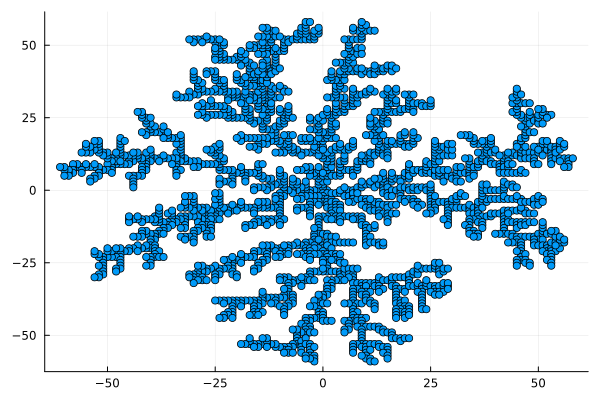

In [64]:
fig = scatter()
scatter!(fig, ([v[1] for v in cluster], [v[2] for v in cluster]), label="")

# Scratchpad

In [72]:
Ref([1,0]) .- [[0,0], [0,1], [-1,0]]

3-element Vector{Vector{Int64}}:
 [1, 0]
 [1, -1]
 [2, 0]

In [74]:
norm([1,1])

1.4142135623730951

In [44]:
maximum(norm.(trajectories[:, 1]))

63.953107821277925

In [53]:
filtered = filter(x -> norm(x) < 2, [[1,3]])

println(filtered)
println(length(filtered))

Vector{Int64}[]
0
